In [4]:
import numpy as np
import pandas as pd

# Load enrollment and verification sets
x_test_e = np.load('./files/x_test_e.npy')
y_test_e = np.load('./files/y_test_e.npy')
s_test_e = np.load('./files/s_test_e.npy')
h_test_e = np.load('./files/h_test_e.npy')

x_test_v = np.load('./files/x_test_v.npy')
y_test_v = np.load('./files/y_test_v.npy')
s_test_v = np.load('./files/s_test_v.npy')
h_test_v = np.load('./files/h_test_v.npy')

# Merge enrollment and verification sets
x_test = np.concatenate((x_test_e, x_test_v), axis=0)
y_test = np.concatenate((y_test_e, y_test_v), axis=0)
s_test = np.concatenate((s_test_e, s_test_v), axis=0)
h_test = np.concatenate((h_test_e, h_test_v), axis=0)

# Select 10 random samples per session
unique_sessions = np.unique(s_test)
selected_indices = []

for session in unique_sessions:
    session_indices = np.where(s_test == session)[0]
    if len(session_indices) > 10:
        selected_indices.extend(np.random.choice(session_indices, 10, replace=False))
    else:
        selected_indices.extend(session_indices)  # Take all if less than 10

# Subset data based on selected indices
x_test_selected = x_test[selected_indices]
y_test_selected = y_test[selected_indices]
s_test_selected = s_test[selected_indices]
h_test_selected = h_test[selected_indices]

# Convert selected data to a DataFrame for better visualization
df_selected = pd.DataFrame({"Session": s_test_selected, "Label": y_test_selected})

# Display the first few rows
print(df_selected.head())


   Session  Label
0        1    332
1        1    261
2        1    336
3        1     70
4        1    130


In [6]:
x_test_selected.shape

(4510, 128)

In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns

# Your data loading and sampling code
x_test_e = np.load('./files/x_test_e.npy')
y_test_e = np.load('./files/y_test_e.npy')
s_test_e = np.load('./files/s_test_e.npy')
h_test_e = np.load('./files/h_test_e.npy')

x_test_v = np.load('./files/x_test_v.npy')
y_test_v = np.load('./files/y_test_v.npy')
s_test_v = np.load('./files/s_test_v.npy')
h_test_v = np.load('./files/h_test_v.npy')

# Merge enrollment and verification sets
x_test = np.concatenate((x_test_e, x_test_v), axis=0)
y_test = np.concatenate((y_test_e, y_test_v), axis=0)
s_test = np.concatenate((s_test_e, s_test_v), axis=0)
h_test = np.concatenate((h_test_e, h_test_v), axis=0)

# Verify shapes (sanity check)
print(f"x_test shape: {x_test.shape}")  # Should be (n_samples, 128)
print(f"y_test shape: {y_test.shape}")
print(f"s_test shape: {s_test.shape}")
print(f"h_test shape: {h_test.shape}")

# Select 10 random samples per unique session-subject combination
unique_sessions = np.unique(s_test)
unique_subjects = np.unique(y_test)
selected_indices = []

for session in unique_sessions:
    for subject in unique_subjects:
        session_subject_indices = np.where((s_test == session) & (y_test == subject))[0]
        if len(session_subject_indices) > 30:
            selected_indices.extend(np.random.choice(session_subject_indices, 30, replace=False))
        elif len(session_subject_indices) > 0:  # Include if at least 1 sample exists
            selected_indices.extend(session_subject_indices)

# Subset data based on selected indices
x_test_selected = x_test[selected_indices]
y_test_selected = y_test[selected_indices]
s_test_selected = s_test[selected_indices]
h_test_selected = h_test[selected_indices]

# Verify subset shapes and counts
print(f"x_test_selected shape: {x_test_selected.shape}")
print(f"Number of unique subjects: {len(np.unique(y_test_selected))}")
print(f"Number of unique sessions: {len(np.unique(s_test_selected))}")

# Step 1: Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42, metric="cosine")
x_tsne = tsne.fit_transform(x_test_selected)
print(f"t-SNE output shape: {x_tsne.shape}")

# Step 2: Compute pairwise cosine distances
cosine_dist = cosine_distances(x_test_selected)
print(f"Cosine distance matrix shape: {cosine_dist.shape}")

# Step 3: Create DataFrame for visualization
df_viz = pd.DataFrame({
    "x": x_tsne[:, 0],
    "y": x_tsne[:, 1],
    "Subject": y_test_selected
})

x_test shape: (170051, 128)
y_test shape: (170051,)
s_test shape: (170051,)
h_test shape: (170051,)
x_test_selected shape: (50948, 128)
Number of unique subjects: 100
Number of unique sessions: 451
t-SNE output shape: (50948, 2)
Cosine distance matrix shape: (50948, 50948)


In [2]:
# Step 3: Compute per-point closeness metric (average distance to k nearest same-subject neighbors)
k = 5  # Number of nearest neighbors to consider
closeness = []
for i, subject in enumerate(y_test_selected):  # Use y_test_selected for subjects
    same_subject_indices = np.where(y_test_selected == subject)[0]
    if len(same_subject_indices) > 1:
        # Distances to other embeddings of the same subject
        distances_to_same = cosine_dist[i, same_subject_indices]
        # Exclude self (distance = 0)
        distances_to_same = distances_to_same[distances_to_same > 0]
        if len(distances_to_same) >= k:
            closeness.append(np.mean(np.sort(distances_to_same)[:k]))
        else:
            closeness.append(np.mean(distances_to_same))
    else:
        closeness.append(np.nan)  # Single-sample subjects get NaN

closeness = np.array(closeness)

# Step 4: Global distinguishability (intra vs. inter-subject distances)
unique_subjects = np.unique(y_test_selected)
intra_distances = []
inter_distances = []

for subject in unique_subjects:
    subject_indices = np.where(y_test_selected == subject)[0]
    other_indices = np.where(y_test_selected != subject)[0]
    
    if len(subject_indices) > 1:
        intra_dist = cosine_dist[np.ix_(subject_indices, subject_indices)]
        intra_distances.extend(intra_dist[np.triu_indices(len(subject_indices), k=1)])
    
    inter_dist = cosine_dist[np.ix_(subject_indices, other_indices)]
    inter_distances.extend(inter_dist.flatten())

avg_intra_dist = np.mean(intra_distances) if intra_distances else 0
avg_inter_dist = np.mean(inter_distances) if inter_distances else 0
print(f"Avg Intra-Subject Cosine Distance: {avg_intra_dist:.3f}")
print(f"Avg Inter-Subject Cosine Distance: {avg_inter_dist:.3f}")
print(f"Distinguishability Ratio (Inter/Intra): {avg_inter_dist / avg_intra_dist if avg_intra_dist > 0 else np.inf:.3f}")



Avg Intra-Subject Cosine Distance: 0.406
Avg Inter-Subject Cosine Distance: 0.790
Distinguishability Ratio (Inter/Intra): 1.945


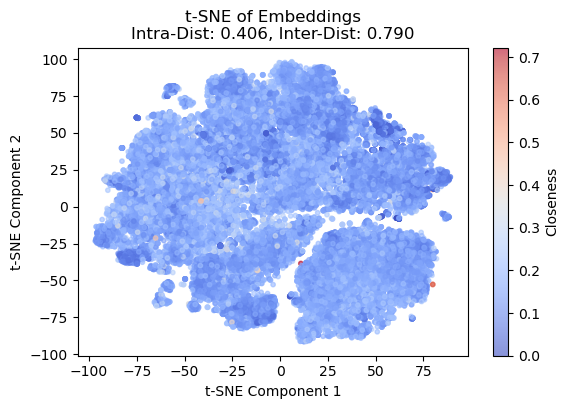

In [7]:
# Step 5: Create DataFrame for visualization
df_viz = pd.DataFrame({
    "y": x_tsne[:, 0],
    "x": x_tsne[:, 1],
    "Closeness": closeness,
    "Subject": y_test_selected
})

# Step 6: Visualize with closeness as color
plt.figure(figsize=(6.3, 4))
scatter = plt.scatter(
    df_viz["x"], df_viz["y"], c=df_viz["Closeness"],
    cmap="coolwarm",  # Colorblind-friendly continuous colormap
    alpha=0.6, s=10, vmin=0, vmax=np.nanmax(closeness)  # Normalize closeness for color scale
)
plt.colorbar(scatter, label="Closeness")
plt.title(f"t-SNE of Embeddings\nIntra-Dist: {avg_intra_dist:.3f}, Inter-Dist: {avg_inter_dist:.3f}")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
output_file = "embedding_space_plot.png"  # You can change the filename and format (e.g., .jpg, .pdf)
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Convert byte strings to normal strings if necessary
h_test_selected = np.array([device.decode('utf-8') if isinstance(device, bytes) else device for device in h_test_selected])


/tmp/ipykernel_1329749/4036420742.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


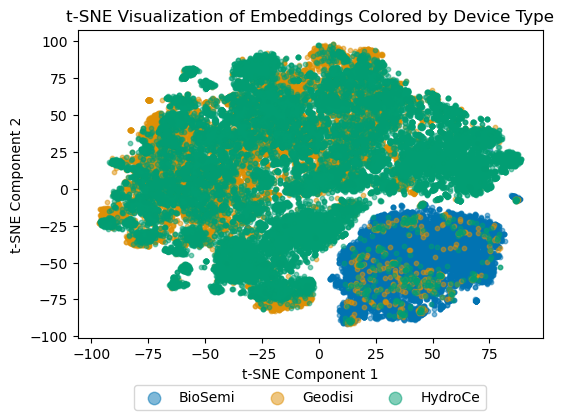

In [24]:
# Step 2: Assign unique colors for each device type
unique_devices = np.unique(h_test_selected)
# device_colors = {device: color for device, color in zip(unique_devices, sns.color_palette("husl", len(unique_devices)))}
device_colors = {device: color for device, color in zip(unique_devices, sns.color_palette("colorblind", len(unique_devices)))}

# Step 3: Plot t-SNE embeddings colored by device type
plt.figure(figsize=(6, 4))
for device in unique_devices:
    indices = np.where(h_test_selected == device)[0]
    plt.scatter(x_tsne[indices, 1], x_tsne[indices, 0], 
                label=f"{device}", color=device_colors[device], alpha=0.5, s=10)

plt.title("t-SNE Visualization of Embeddings Colored by Device Type")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Increase marker size in legend
legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.13), ncol=3)
for handle in legend.legendHandles:
    handle.set_sizes([80])  # Adjust legend bullet size

# Save the figure
output_file = "embedding_space_device.png"  # You can change the filename and format (e.g., .jpg, .pdf)
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()
